# Example: Using Multiple Different Fingerprint Transformer

In this notebook we will explore how to evaluate the performance of machine learning models depending on different fingerprint transformers (Featurization techniques). This is an example, that you easily could adapt for many different combinations of featurizers, optimizaiton and other modelling techniques.

Following steps will happen:
* Data Parsing
* Pipeline Building
* Training Phase
* Analysis

Authors: @VincentAlexanderScholz, @RiesBen 

## Imports:
First we will import all the stuff that we will need for our work.


In [1]:
import os
import numpy as np
import pandas as pd
from time import time
from matplotlib import pyplot as plt

from rdkit.Chem import PandasTools

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

from scikit_mol import fingerprints


## Get Data:
In this step we will check if the SLC6A4 data set is already present or needs to be downloaded.


**WARNING:** The Dataset is a simple and very well selected

In [2]:
full_set = False

# if not present download example data
if full_set:
    csv_file = "SLC6A4_active_excape_export.csv"
    if not os.path.exists(csv_file):
        import urllib.request
        url = "https://ndownloader.figshare.com/files/25747817"
        urllib.request.urlretrieve(url, csv_file)
else:
    csv_file = '../tests/data/SLC6A4_active_excapedb_subset.csv'

#Parse Database
data = pd.read_csv(csv_file)

PandasTools.AddMoleculeColumnToFrame(data, smilesCol="SMILES")
print(f"{data.ROMol.isna().sum()} out of {len(data)} SMILES failed in conversion")

0 out of 200 SMILES failed in conversion


## Build Pipeline:
In this stage we will build the Pipeline consisting of the featurization part (finger print transformers) and the model part (Ridge Regression).

Note that the featurization in this section is an hyperparameter, living in `param_grid`, and the `"fp_transformer"` string is just a placeholder, being replaced during pipeline execution. 

This way we can define multiple different scenarios in `param_grid`, that allow us to rapidly explore different combinations of settings and methodologies.

In [9]:

regressor = Ridge()
optimization_pipe = Pipeline([("fp_transformer", "fp_transformer"), # this is a placeholder for different transformers
                              ("regressor", regressor)])

param_grid = [ # Here pass different Options and Approaches
    {
        "fp_transformer": [fingerprints.MorganFingerprintTransformer(),
                          fingerprints.AvalonFingerprintTransformer()],
        "fp_transformer__nBits": [2**x for x in range(8,13)],
    },
    {
       "fp_transformer": [fingerprints.RDKitFingerprintTransformer(),
                         fingerprints.AtomPairFingerprintTransformer(),
                         fingerprints.MACCSKeysFingerprintTransformer()], 
    },
]

global_options = {
    "regressor__alpha": np.linspace(0.1,1,5),
}

[params.update(global_options) for params in param_grid]

param_grid

[{'fp_transformer': [MorganFingerprintTransformer(),
   AvalonFingerprintTransformer()],
  'fp_transformer__nBits': [256, 512, 1024, 2048, 4096],
  'regressor__alpha': array([0.1  , 0.325, 0.55 , 0.775, 1.   ])},
 {'fp_transformer': [RDKitFingerprintTransformer(),
   AtomPairFingerprintTransformer(),
   MACCSKeysFingerprintTransformer()],
  'regressor__alpha': array([0.1  , 0.325, 0.55 , 0.775, 1.   ])}]

## Train Model
In this section, the combinatorial approaches are trained.

In [11]:
# Split Data
mol_list_train, mol_list_test, y_train, y_test = train_test_split(data.ROMol, data.pXC50, random_state=0)

# Define Search Process
grid = GridSearchCV(optimization_pipe, n_jobs=1,
                    param_grid=param_grid)

# Train
t0 = time()
grid.fit(mol_list_train, y_train.values)
t1 = time()

print(f'Runtime: {t1-t0:0.2F}')

Runtime: 21.57


## Analysis

Now let's investigate our results from the training stage. Which one is the best finger print method for this data set? Which parameters are optimal?

In [12]:
df_training_stats = pd.DataFrame(grid.cv_results_)
df_training_stats

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fp_transformer,param_fp_transformer__nBits,param_regressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008875,0.000990,0.002437,0.000475,MorganFingerprintTransformer(nBits=1024),256,0.1,{'fp_transformer': MorganFingerprintTransforme...,0.017975,0.394682,0.524598,0.542116,0.310238,0.357922,0.190209,25
1,0.008246,0.000058,0.002174,0.000060,MorganFingerprintTransformer(nBits=1024),256,0.325,{'fp_transformer': MorganFingerprintTransforme...,0.078758,0.449548,0.554241,0.572363,0.330543,0.397090,0.181071,24
2,0.008223,0.000073,0.002163,0.000057,MorganFingerprintTransformer(nBits=1024),256,0.55,{'fp_transformer': MorganFingerprintTransforme...,0.128221,0.490253,0.575230,0.593237,0.344076,0.426203,0.173061,23
3,0.008222,0.000065,0.002162,0.000051,MorganFingerprintTransformer(nBits=1024),256,0.775,{'fp_transformer': MorganFingerprintTransforme...,0.169585,0.521723,0.590890,0.608380,0.353866,0.448889,0.166100,22
4,0.008224,0.000041,0.002179,0.000069,MorganFingerprintTransformer(nBits=1024),256,1.0,{'fp_transformer': MorganFingerprintTransforme...,0.204831,0.546774,0.603010,0.619752,0.361324,0.467138,0.160060,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.085614,0.001485,0.021641,0.001508,MACCSKeysFingerprintTransformer(),NaN,0.1,{'fp_transformer': MACCSKeysFingerprintTransfo...,-1.649022,-1.943461,-0.602509,-0.418328,-0.752525,-1.073169,0.606987,65
61,0.085732,0.001294,0.021640,0.001489,MACCSKeysFingerprintTransformer(),NaN,0.325,{'fp_transformer': MACCSKeysFingerprintTransfo...,-0.969593,-0.813087,-0.188690,0.003831,-0.314764,-0.456461,0.372595,64
62,0.085645,0.001406,0.021650,0.001574,MACCSKeysFingerprintTransformer(),NaN,0.55,{'fp_transformer': MACCSKeysFingerprintTransfo...,-0.657588,-0.505782,-0.045940,0.124510,-0.171340,-0.251228,0.289700,62
63,0.085554,0.001441,0.021606,0.001475,MACCSKeysFingerprintTransformer(),NaN,0.775,{'fp_transformer': MACCSKeysFingerprintTransfo...,-0.468371,-0.356825,0.036642,0.182939,-0.087318,-0.138587,0.242115,59


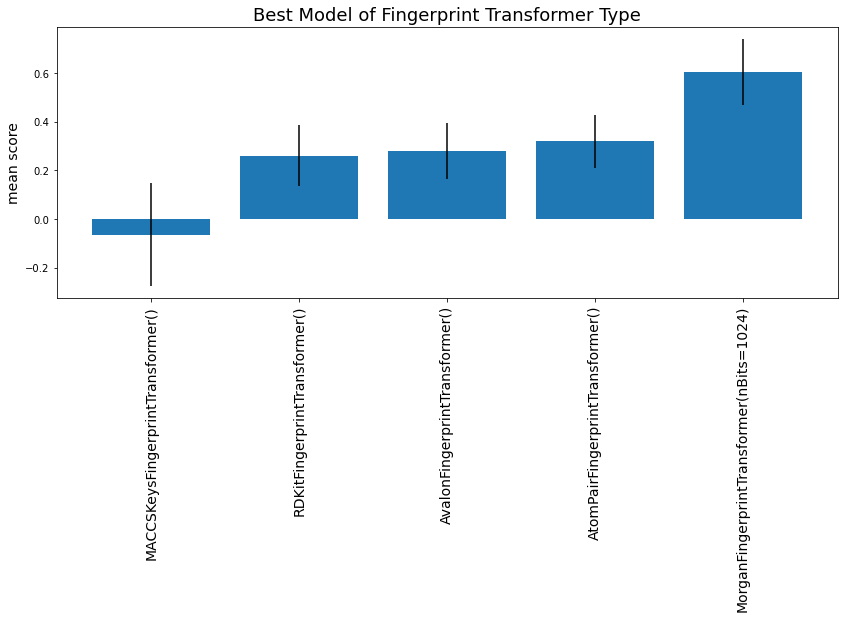

In [77]:
# Best Fingerprint Method / Performance
res_dict = {}
for i, row in df_training_stats.iterrows():
    fp_name = row['param_fp_transformer'] 
    if(fp_name in res_dict and row['mean_test_score'] > res_dict[fp_name]["mean_test_score"]):
        res_dict[fp_name] = row.to_dict()
    elif(not fp_name in res_dict):
        res_dict[fp_name] = row.to_dict()
        
df = pd.DataFrame(list(res_dict.values()))
df =df.sort_values(by="mean_test_score")

#plot test score vs. approach
plt.figure(figsize=[14,5])
plt.bar(range(len(df)), df.mean_test_score, yerr=df.std_test_score)
plt.xticks(range(len(df)), df.param_fp_transformer, rotation=90, fontsize=14)
plt.ylabel("mean score", fontsize=14)
plt.title("Best Model of Fingerprint Transformer Type", fontsize=18)
pass


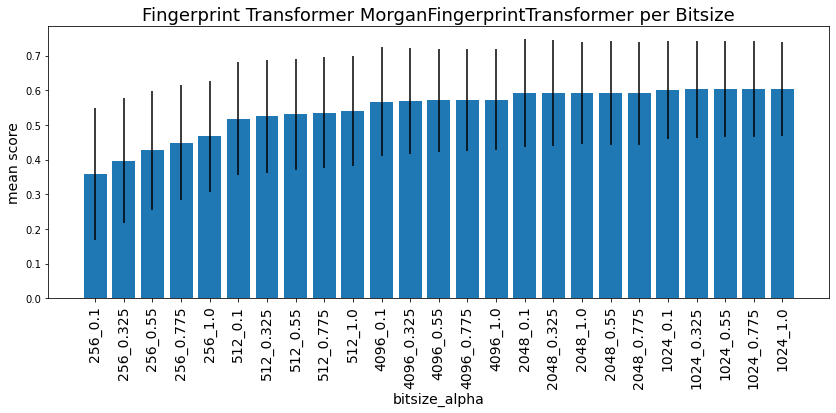

In [78]:
# Best Fingerprint Method / Performance
from collections import defaultdict
res_dict = defaultdict(list)
for i, row in df_training_stats.iterrows():
    fp_name = row['param_fp_transformer'] 
    if("Morgan" in str(fp_name)):
        res_dict[fp_name].append(row)

for fp_type, rows in res_dict.items():
    df = pd.DataFrame(rows)
    df =df.sort_values(by="mean_test_score")

    #plot test score vs. approach
    xlabels = map(lambda x: "_".join(x), zip(df.param_fp_transformer__nBits.astype(str), df.param_regressor__alpha.astype(str)))

        
    plt.figure(figsize=[14,5])
    plt.bar(range(len(df)), df.mean_test_score, yerr=df.std_test_score)
    plt.xticks(range(len(df)), xlabels, rotation=90, fontsize=14)
    plt.ylabel("mean score", fontsize=14)
    plt.xlabel("bitsize_alpha", fontsize=14)

    plt.title("Fingerprint Transformer "+str(fp_type).split("(")[0]+" per Bitsize", fontsize=18)
    pass


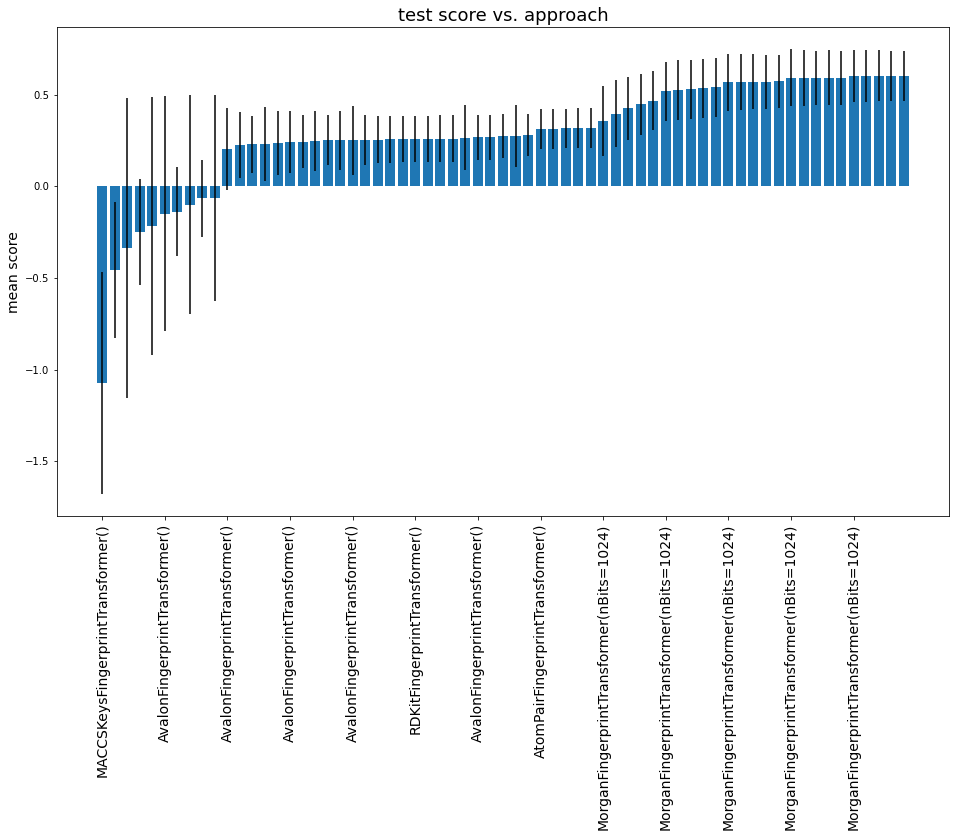

In [79]:
#plot ALL test score vs. approach
df =df_training_stats.sort_values(by="mean_test_score")

plt.figure(figsize=[16,9])
plt.bar(range(len(df)), df.mean_test_score, yerr=df.std_test_score)
plt.ylabel("mean score", fontsize=14)
plt.xticks(range(len(df))[::5], df.param_fp_transformer[::5], rotation=90, fontsize=14)
plt.title("test score vs. approach", fontsize=18)
pass